In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
events_df = pd.read_csv('epl_event_data_15.csv')
events_df.head()

,id,index,period,timestamp,minute,second,possession,player_possession,duration,related_events,...,pass.end_location,dribble.outcome.id,dribble.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,carry.end_location,duel.outcome.id,duel.outcome.name,competition_id,match_id
0,9153e9f4-f69c-4e04-8f64-505592e212cd,1,1,00:00:00.000,0,0,1,1,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
1,3fbcf4e7-94d1-485a-be85-fd26a6af0318,2,1,00:00:00.000,0,0,1,2,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
2,06a9a4dc-d9c9-40f6-bd89-437ba7fe682d,3,1,00:00:00.000,0,0,1,3,0.000000,100362ee-9311-4187-bd8a-0201d9db2565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
3,100362ee-9311-4187-bd8a-0201d9db2565,4,1,00:00:00.000,0,0,1,4,0.000000,06a9a4dc-d9c9-40f6-bd89-437ba7fe682d,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
4,2ca23eea-a984-47e4-8243-8f00880ad1c9,5,1,00:00:01.753,0,1,2,5,0.308263,1f98c89e-2326-4200-8c12-a987fdbbaf2e,...,"60.4, 43.6",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058


In [3]:
events_df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'player_possession', 'duration', 'related_events', 'location',
       'under_pressure', 'counterpress', 'type.id', 'type.name',
       'possession_team.id', 'possession_team.name', 'play_pattern.id',
       'play_pattern.name', 'team.id', 'team.name', 'tactics.formation',
       'tactics.lineup', 'player.id', 'player.name', 'position.id',
       'position.name', 'pass.length', 'pass.angle', 'pass.height.id',
       'pass.height.name', 'pass.body_part.id', 'pass.body_part.name',
       'pass.type.id', 'pass.type.name', 'pass.outcome.id',
       'pass.outcome.name', 'pass.receipient.id', 'pass.recipient.name',
       'pass.end_location', 'dribble.outcome.id', 'dribble.outcome.name',
       'ball_receipt.outcome.id', 'ball_receipt.outcome.name',
       'carry.end_location', 'duel.outcome.id', 'duel.outcome.name',
       'competition_id', 'match_id'],
      dtype='object')

# Definition of Player Possession Chains and Modeling Objective

## Objective

The objective of this work is to predict the probability that a player will win a foul during their own possession of the ball. Specifically, the model aims to determine whether a player will win a foul after they have received or recovered the ball during a team possession.

---

## Definition of a Player Possession Chain

A player possession chain is defined as a sequence of consecutive events that occur during a single team possession, in which a specific player is in control of the ball. This concept isolates the player's individual control within the broader team context.

---

## Start of a Chain

A player possession chain begins when the player:

- Receives the ball (event type: `Ball Receipt*`)
- Recovers the ball (event type: `Ball Recovery`)

---

## End of a Chain

The chain ends when any of the following occur:

- The player wins a foul (event type: `Foul Won`)
- The player loses the ball

---

## Relevance of This Definition

This definition ensures that only player-specific actions within their period of control are used as input to the model. It allows for targeted modeling of foul outcomes by isolating the relevant sequence of events where the player’s actions are most likely to lead to a foul being drawn.

In [8]:
# identify possession chains

events_df['type.name'] = events_df['type.name'].str.replace('*', '').str.strip()
events_df['type.name'].value_counts()

type.name
Pass                 368619
Ball Receipt         340324
Carry                276949
Pressure             115402
Ball Recovery         40943
Duel                  32290
Clearance             21645
Block                 14839
Dribble               13721
Goal Keeper           11777
Miscontrol            10786
Dispossessed          10520
Shot                   9908
Foul Committed         9512
Foul Won               9112
Interception           8920
Dribbled Past          8771
Substitution           2109
Half Start             1520
Half End               1520
Injury Stoppage        1032
Starting XI             760
Tactical Shift          625
50/50                   559
Shield                  503
Referee Ball-Drop       272
Bad Behaviour           193
Error                   178
Player Off              145
Player On               144
Offside                 109
Own Goal Against         38
Own Goal For             38
Name: count, dtype: int64

In [13]:
# event cleanup - remove events which are not relevant to the target
events_df['type.name'] = events_df['type.name'].str.lower().str.replace(" ", "_")

events_to_exclude = [
    "substitution", "player_on", "player_off", "injury_stoppage",
    "goal_keeper", "error", "offside", "half_start", "half_end", "starting_xi",
    "referee_ball-drop", "own_goal_against", "own_goal_for"
]

events_df = events_df[~events_df['type.name'].isin(events_to_exclude)]
events_df.shape

(1294141, 49)

In [14]:
events_df['type.name'].value_counts()

type.name
pass              368619
ball_receipt      340324
carry             276949
pressure          115402
ball_recovery      40943
duel               32290
clearance          21645
block              14839
dribble            13721
miscontrol         10786
dispossessed       10520
shot                9908
foul_committed      9512
foul_won            9112
interception        8920
dribbled_past       8771
tactical_shift       625
50/50                559
shield               503
bad_behaviour        193
Name: count, dtype: int64

In [48]:
def parse_timestamp(ts):
    # '00:32:18.937' → seconds
    if isinstance(ts, str):
        t = pd.to_timedelta("00:" + ts.split(":")[-2] + ":" + ts.split(":")[-1])
        return t.total_seconds()
    return None

def analyze_possession_chain(chain, match_id, possession_id, player_id):
    chain = chain.sort_values(["minute", "second", "index"])  # ensure order
    # truncate chain if foul won present
    for i, row in chain.iterrows():
        if row["type.name"] == "foul_won":
            chain = chain.loc[:i]
    # Basic event flow
    event_sequence = chain["type.name"].tolist()
    unique_events = list(set(event_sequence))
    num_events = len(event_sequence)
    
    # Team vs Opponent
    start_team = chain["team.id"].iloc[0]
    num_team_events = (chain["team.id"] == start_team).sum()
    num_opponent_events = (chain["team.id"] != start_team).sum()

    # number of players involved
    num_players_start_team = chain[chain["team.id"] == start_team]['player.id'].nunique()
    num_players_opponent_team = chain[chain["team.id"] != start_team]['player.id'].nunique()
    
    # Opponent actions
    num_opponent_duels = chain[
        (chain["team.id"] != start_team) & (chain["type.name"] == "duel")
    ].shape[0]

    num_opponent_pressures = chain[
        (chain["team.id"] != start_team) & (chain["type.name"] == "pressure")
    ].shape[0]

    # Chain dynamics
    ended_in_event = chain["type.name"].iloc[-1]
    ended_in_duel_or_dispossess = ended_in_event in ["duel", "dispossessed"]

    # Transitions: Pass → Dribble
    transitions = list(zip(event_sequence, event_sequence[1:]))
    num_pass_to_dribble = transitions.count(("pass", "dribble"))

    # Time duration
    chain["parsed_timestamp"] = chain["timestamp"].apply(parse_timestamp)
    time_duration = chain["parsed_timestamp"].iloc[-1] - chain["parsed_timestamp"].iloc[0]

    # play patterns
    play_pattern_sequence = chain["play_pattern.name"].tolist()
    
    return {
        # "player_possession": possession_id,
        "match_id": match_id,
        "possession_id": possession_id,
        "player_id": player_id,
        "event_sequence": event_sequence,
        "unique_event_types": unique_events,
        "num_events": num_events,
        "num_team_events": num_team_events,
        "num_players": num_players_start_team,
        "num_opponent_players": num_players_opponent_team,
        "num_opponent_events": num_opponent_events,
        "num_opponent_duels": num_opponent_duels,
        "num_opponent_pressures": num_opponent_pressures,
        "ended_in_duel_or_dispossess": int(ended_in_duel_or_dispossess),
        "num_pass_to_dribble": num_pass_to_dribble,
        "play_patterns": play_pattern_sequence,
        "time_duration_seconds": time_duration,
    }

In [6]:
events_df.loc[events_df['type.name'].isin(['Ball Recovery', 'Ball Receipt']), ['match_id','possession']].head()

,match_id,possession
5,3754058,2
8,3754058,2
10,3754058,2
13,3754058,2
16,3754058,2


In [17]:
pd.set_option('display.max_columns',None)
start_events = events_df[events_df["type.name"].isin(['ball_recovery', 'ball_receipt'])]
start_events = start_events.groupby(["match_id","possession","player.id"]).size().reset_index(name="n_events")
start_events.head()

,match_id,possession,player.id,n_events
0,3753972,2,3057.0,1
1,3753972,2,3262.0,1
2,3753972,2,3605.0,1
3,3753972,2,3644.0,4
4,3753972,2,4631.0,1


In [56]:
start_events.shape

(278699, 4)

In [18]:
start_events.n_events.describe()

count    278699.000000
mean          1.368024
std           0.764079
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          18.000000
Name: n_events, dtype: float64

In [19]:
start_events[start_events.n_events > 1].shape

(71152, 4)

In [20]:
# Remove player possession chains with only one event
filtered_start_events = start_events[start_events.n_events > 1]

In [64]:
events_df[events_df['type.name'] == 'Foul Won'].head(10)

,id,index,period,timestamp,minute,second,possession,player_possession,duration,related_events,location,under_pressure,counterpress,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,player.id,player.name,position.id,position.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.body_part.id,pass.body_part.name,pass.type.id,pass.type.name,pass.outcome.id,pass.outcome.name,pass.receipient.id,pass.recipient.name,pass.end_location,dribble.outcome.id,dribble.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,carry.end_location,duel.outcome.id,duel.outcome.name,competition_id,match_id
304,e2b23fc3-7012-4a52-b1f9-05c7fbed63e7,305,1,00:05:48.686,5,48,13,122,0.0,d3628ab0-f089-41a5-bbeb-3c00887594d5,"22.3, 76.7",True,NaN,21,Foul Won,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3049.0,Matt Ritchie,12.0,Right Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
384,73aaf4ac-139d-47dc-a0e6-3066d103b06b,385,1,00:08:14.319,8,14,14,155,0.0,ae4bc28c-f526-488b-9f16-bd858966a264,"65.7, 26.1",True,NaN,21,Foul Won,28,AFC Bournemouth,4,From Throw In,28,AFC Bournemouth,NaN,NaN,3346.0,Joshua King,23.0,Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
645,dc660f42-07f9-422a-ae25-289a553c9376,646,1,00:14:40.290,14,40,24,259,0.0,"2b5c24dd-65cd-47ec-b712-b36e97ec6600, 5b1aac7c...","81.6, 18.5",True,NaN,21,Foul Won,22,Leicester City,1,Regular Play,22,Leicester City,NaN,NaN,3307.0,Marc Albrighton,16.0,Left Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
852,61b87943-22ed-42fa-b41d-b569ad703eb5,853,1,00:19:45.731,19,45,36,356,0.0,"28544a98-b437-4e2b-a462-5b7ebe02cd51, 9a779e6b...","73.8, 63.7",True,NaN,21,Foul Won,28,AFC Bournemouth,4,From Throw In,28,AFC Bournemouth,NaN,NaN,3344.0,Andrew Surman,10.0,Center Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
897,c9320f87-df13-473e-9ef9-3922af783665,898,1,00:20:48.697,20,48,38,378,0.0,4bef9249-39b1-424c-8896-58acadb2aff5,"63.2, 54.9",NaN,NaN,21,Foul Won,22,Leicester City,4,From Throw In,22,Leicester City,NaN,NaN,3671.0,José Leonardo Ulloa,22.0,Right Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
1011,f63df15f-c45c-4f49-b93d-9c66beb0bccb,1012,1,00:22:44.740,22,44,42,420,0.0,44a52b43-ef04-47d5-af06-7367a54294f6,"69.3, 26.7",True,NaN,21,Foul Won,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3304.0,Harry Arter,15.0,Left Center Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
1160,f60e63a4-4629-4375-8250-87fb75ac2c7c,1161,1,00:25:07.011,25,7,46,477,0.0,95e592ad-205c-489c-a524-c7f641463e14,"38.1, 71.8",True,NaN,21,Foul Won,22,Leicester City,1,Regular Play,22,Leicester City,NaN,NaN,3671.0,José Leonardo Ulloa,22.0,Right Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
1483,ac819a8c-fce4-4880-bd47-954fecb0d9ae,1484,1,00:33:15.643,33,15,61,613,0.0,37452226-baa8-499a-a49e-9cd6d908c29c,"67.7, 49.8",True,NaN,21,Foul Won,22,Leicester City,1,Regular Play,22,Leicester City,NaN,NaN,3961.0,N''Golo Kanté,11.0,Left Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
1527,4c7aafaf-3cda-4743-9eaf-f549bd6a9c25,1528,1,00:34:32.724,34,32,65,633,0.0,62fb092b-fbfd-4039-bc0b-2d599e756e2a,"58.4, 9.4",True,NaN,21,Foul Won,28,AFC Bournemouth,1,Regular Play,28,AFC Bournemouth,NaN,NaN,3304.0,Harry Arter,15.0,Left Center Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3754058
1566,0554c891-e806-49f8-b863-b6da12f4b510,1567,1,00:35:17.655,35,17,67,647,0.0,"0ea19568-0fde-4803-bc20-0103f99f97e9, 7fec9ce3...","93.9, 69.9",True,NaN,21,Foul 

In [49]:
# max_events = 100 # for testing
player_possession_chains = []

for i, row in filtered_start_events.iterrows():
    match_id = row['match_id']
    possession_id = row['possession']
    player_id = row['player.id']
    player_possession_chain = events_df[
        (events_df['match_id'] == match_id)
        & (events_df["possession"] == possession_id)
        & (events_df["player.id"] == player_id)
    ].copy()
    
    player_possession_chains.append(analyze_possession_chain(player_possession_chain, match_id, possession_id, player_id))

In [50]:
player_possession_chains_df = pd.DataFrame(player_possession_chains)
player_possession_chains_df.shape

(71152, 16)

## Write player possession df to disk

In [51]:
# write possession df to disk

player_possession_chains_df.to_csv("player_possession_chains.csv")

In [52]:
player_possession_chains_df.head()

,match_id,possession_id,player_id,event_sequence,unique_event_types,num_events,num_team_events,num_players,num_opponent_players,num_opponent_events,num_opponent_duels,num_opponent_pressures,ended_in_duel_or_dispossess,num_pass_to_dribble,play_patterns,time_duration_seconds
0,3753972.0,2.0,3644.0,"[ball_receipt, carry, pass, ball_receipt, carr...","[pass, ball_receipt, carry]",10,10,1,0,0,0,0,0,0,"[From Kick Off, From Kick Off, From Kick Off, ...",17.451
1,3753972.0,2.0,4726.0,"[ball_receipt, carry, pass, ball_receipt, carr...","[pass, ball_receipt, carry]",6,6,1,0,0,0,0,0,0,"[From Kick Off, From Kick Off, From Kick Off, ...",8.303
2,3753972.0,3.0,3049.0,"[ball_receipt, carry, pass, ball_receipt, carr...","[pass, ball_receipt, carry]",6,6,1,0,0,0,0,0,0,"[Regular Play, Regular Play, Regular Play, Reg...",22.292
3,3753972.0,3.0,3304.0,"[ball_receipt, carry, pass, pass, ball_receipt...","[pass, ball_receipt, carry]",7,7,1,0,0,0,0,0,0,"[Regular Play, Regular Play, Regular Play, Reg...",40.965
4,3753972.0,3.0,3343.0,"[ball_receipt, carry, pass, pressure, ball_rec...","[pressure, pass, ball_receipt, carry]",8,8,1,0,0,0,0,0,0,"[Regular Play, Regular Play, Regular Play, Reg...",29.319


In [44]:
player_possession_chains_df.columns

Index(['match_id', 'possession_id', 'player_id', 'event_sequence',
       'unique_event_types', 'num_events', 'num_team_events', 'num_players',
       'num_opponent_players', 'num_opponent_events', 'num_opponent_duels',
       'num_opponent_pressures', 'ended_in_duel_or_dispossess',
       'num_pass_to_dribble', 'time_duration_seconds'],
      dtype='object')

# Duration of a possession chain

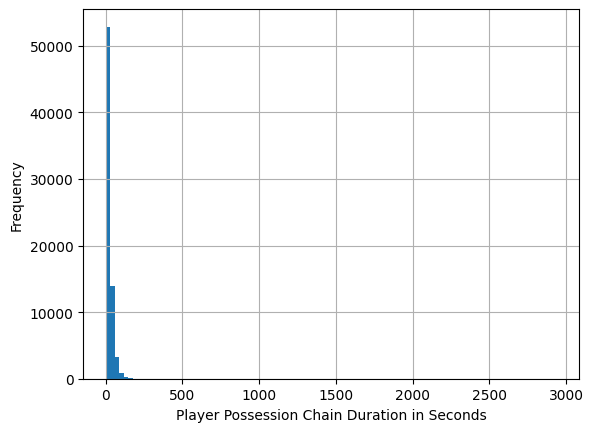

In [53]:
player_possession_chains_df.time_duration_seconds.hist(bins=100)
plt.xlabel("Player Possession Chain Duration in Seconds")
plt.ylabel("Frequency")
# plt.ylim(0,500)
plt.show()

In [54]:
player_possession_chains_df.time_duration_seconds.describe()

count    71152.000000
mean        23.580745
std         56.766595
min          0.000000
25%          8.510000
50%         16.121000
75%         29.924000
max       2938.875000
Name: time_duration_seconds, dtype: float64

In [55]:
player_possession_chains_df.num_events.describe()

count    71152.000000
mean         6.794496
std          2.838158
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         49.000000
Name: num_events, dtype: float64

In [56]:
player_possession_chains_df[player_possession_chains_df.time_duration_seconds > 2000]

,match_id,possession_id,player_id,event_sequence,unique_event_types,num_events,num_team_events,num_players,num_opponent_players,num_opponent_events,num_opponent_duels,num_opponent_pressures,ended_in_duel_or_dispossess,num_pass_to_dribble,play_patterns,time_duration_seconds
2250,3753983.0,94.0,3644.0,"[ball_receipt, ball_receipt, carry, pass]","[pass, ball_receipt, carry]",4,4,1,0,0,0,0,0,0,"[From Throw In, From Throw In, From Throw In, ...",2868.050
6197,3754003.0,98.0,18872.0,"[ball_receipt, ball_receipt, carry, pass]","[pass, ball_receipt, carry]",4,4,1,0,0,0,0,0,0,"[Regular Play, Regular Play, Regular Play, Reg...",2754.999
9697,3754022.0,95.0,3469.0,"[ball_receipt, ball_receipt, carry, pass]","[pass, ball_receipt, carry]",4,4,1,0,0,0,0,0,0,"[From Throw In, From Throw In, From Throw In, ...",2899.364
13145,3754041.0,91.0,3450.0,"[ball_receipt, ball_receipt, carry, pass]","[pass, ball_receipt, carry]",4,4,1,0,0,0,0,0,0,"[Regular Play, Regular Play, Regular Play, Reg...",2693.359
18766,3754071.0,78.0,3321.0,"[ball_receipt, ball_receipt, pass]","[ball_receipt, pass]",3,3,1,0,0,0,0,0,0,"[From Throw In, From Throw In, From Throw In]",2938.875
21104,3754083.0,80.0,3381.0,"[ball_receipt, ball_receipt, carry, pass, ball...","[pass, ball_receipt, carry]",15,15,1,0,0,0,0,0,0,"[From Throw In, From Throw In, From Throw In, ...",2754.036
26036,3754110.0,88.0,3090.0,"[ball_receipt, ball_receipt, carry, pass, ball...","[pass, ball_receipt, carry]",9,9,1,0,0,0,0,0,0,"[From Throw In, From Throw In, From Throw In, ...",2839.377
27691,3754118.0,93.0,3496.0,"[ball_receipt, ball_receipt, carry, pass, ball...","[pass, ball_receipt, carry]",10,10,1,0,0,0,0,0,0,"[Regular Play, Regular Play, Regular Play, Reg...",2806.851
29549,3754128.0,92.0,3608.0,"[ball_receipt, ball_receipt, pass]","[ball_receipt, pass]",3,3,1,0,0,0,0,0,0,"[Regular Play, Regular Play, Regular Play]",2777.612
30587,3754134.0,90.0,3595.0,"[ball_receipt, ball_receipt, carry, pass, pass]","[pass, ball_receipt, carry]",5,5,1,0,0,0,0,0,0,"[Regular Play, Regular Play, Regular Play, Reg...",2787.648


In [28]:
events_df[
    (events_df.match_id == 3753983.0)
    & (events_df.possession == 94.0)
    & (events_df['player.id'] == 3644.0)
]

,id,index,period,timestamp,minute,second,possession,player_possession,duration,related_events,location,under_pressure,counterpress,type.id,type.name,possession_team.id,possession_team.name,play_pattern.id,play_pattern.name,team.id,team.name,tactics.formation,tactics.lineup,player.id,player.name,position.id,position.name,pass.length,pass.angle,pass.height.id,pass.height.name,pass.body_part.id,pass.body_part.name,pass.type.id,pass.type.name,pass.outcome.id,pass.outcome.name,pass.receipient.id,pass.recipient.name,pass.end_location,dribble.outcome.id,dribble.outcome.name,ball_receipt.outcome.id,ball_receipt.outcome.name,carry.end_location,duel.outcome.id,duel.outcome.name,competition_id,match_id
104421,057ba909-c29a-4ca1-9437-c44d000110cc,1918,1,00:47:46.731,47,46,94,792,NaN,12d7dc8f-7bc2-4360-96be-f2d03d07a07d,"26.4, 30.8",NaN,NaN,42,ball_receipt,26,Swansea City,4,From Throw In,26,Swansea City,NaN,NaN,3644.0,Ashley Williams,5.0,Left Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3753983
104422,a7b5a4ac-b9c0-417b-adde-6f7d837ec35a,1919,1,00:47:46.731,47,46,94,792,2.195480,"057ba909-c29a-4ca1-9437-c44d000110cc, d88cc670...","26.4, 30.8",NaN,NaN,43,carry,26,Swansea City,4,From Throw In,26,Swansea City,NaN,NaN,3644.0,Ashley Williams,5.0,Left Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"27.8, 30.1",NaN,NaN,2,3753983
104423,d88cc670-4c32-40f9-b5d8-d3ba01ad71c1,1920,1,00:47:48.927,47,48,94,792,1.732556,5cee2dc5-ec8b-4fa4-a8d6-e089ac9f7372,"27.8, 30.1",NaN,NaN,30,pass,26,Swansea City,4,From Throw In,26,Swansea City,NaN,NaN,3644.0,Ashley Williams,5.0,Left Center Back,34.75198,1.625497,1.0,Ground Pass,40.0,Right Foot,NaN,NaN,NaN,NaN,NaN,Federico Fernández,"25.9, 64.8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3753983
104427,490dbd2c-dc26-4a79-aaac-a72eb35415d6,1924,1,00:00:00.877,0,0,94,794,NaN,e650435b-2b25-40ac-8aa6-3cc9086cf13d,"35.5, 29.7",NaN,NaN,42,ball_receipt,26,Swansea City,4,From Throw In,26,Swansea City,NaN,NaN,3644.0,Ashley Williams,5.0,Left Center Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3753983


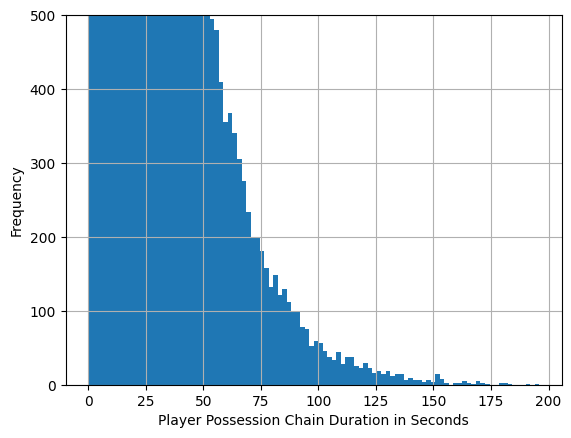

In [57]:
player_possession_chains_df[player_possession_chains_df.time_duration_seconds < 2000]['time_duration_seconds'].hist(bins=100)
plt.xlabel("Player Possession Chain Duration in Seconds")
plt.ylabel("Frequency")
plt.ylim(0,500)
plt.show()

In [58]:
player_possession_chains_df[player_possession_chains_df.time_duration_seconds < 2000]['time_duration_seconds'].describe()

count    71126.000000
mean        22.566840
std         20.216253
min          0.000000
25%          8.509000
50%         16.115500
75%         29.896750
max        195.908000
Name: time_duration_seconds, dtype: float64

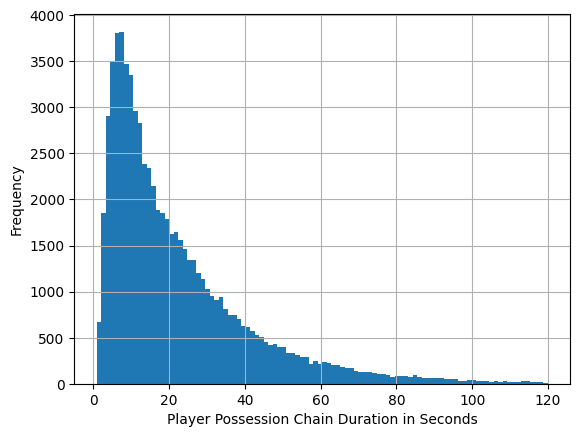

In [59]:
filtered_chains = player_possession_chains_df[
    (player_possession_chains_df["num_events"] >= 2) &
    (player_possession_chains_df["time_duration_seconds"] >= 1) &
    (player_possession_chains_df["time_duration_seconds"] <= 120)
]

filtered_chains['time_duration_seconds'].hist(bins=100)
plt.xlabel("Player Possession Chain Duration in Seconds")
plt.ylabel("Frequency")
# plt.ylim(0,500)
plt.show()

# Add target label

In [60]:
"""
    For each player possession chain, we check to see if the player won the foul
"""

player_possession_chains_df["target_foul_won"] = player_possession_chains_df["event_sequence"].apply(
    lambda seq: int("foul_won" in seq)
)

In [61]:
player_possession_chains_df["target_foul_won"].value_counts()

target_foul_won
0    69506
1     1646
Name: count, dtype: int64

In [62]:
player_possession_chains_df["target_foul_won"].value_counts(normalize=True)

target_foul_won
0    0.976866
1    0.023134
Name: proportion, dtype: float64

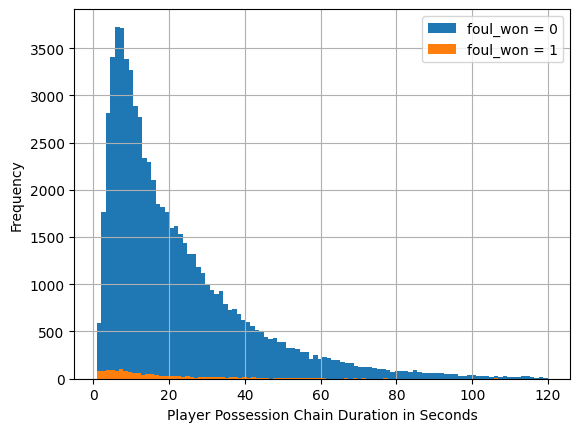

In [63]:
filtered_chains = player_possession_chains_df[
    (player_possession_chains_df["num_events"] >= 2) &
    (player_possession_chains_df["time_duration_seconds"] >= 1) &
    (player_possession_chains_df["time_duration_seconds"] <= 120)
]

filtered_chains[filtered_chains['target_foul_won'] == 0]['time_duration_seconds'].hist(bins=100, label='foul_won = 0')
filtered_chains[filtered_chains['target_foul_won'] == 1]['time_duration_seconds'].hist(bins=100, label='foul_won = 1')

plt.xlabel("Player Possession Chain Duration in Seconds")
plt.ylabel("Frequency")
# plt.ylim(0,500)
plt.legend()
plt.show()

In [39]:
filtered_chains[filtered_chains["target_foul_won"] == 1]['event_sequence'].values[:10]

array([list(['ball_receipt', 'pass', 'foul_won', 'ball_receipt', 'pressure', 'block']),
       list(['ball_receipt', 'carry', 'pass', 'ball_receipt', 'carry', 'pass', 'ball_receipt', 'carry', 'pass', 'ball_receipt', 'carry', 'pass', 'ball_receipt', 'carry', 'foul_won']),
       list(['ball_receipt', 'ball_receipt', 'carry', 'foul_won']),
       list(['ball_receipt', 'pass', 'pressure', 'ball_recovery', 'carry', 'foul_won']),
       list(['ball_receipt', 'carry', 'miscontrol', 'pressure', 'block', 'ball_recovery', 'carry', 'foul_won']),
       list(['ball_receipt', 'carry', 'pass', 'ball_receipt', 'carry', 'foul_won']),
       list(['ball_receipt', 'pass', 'ball_receipt', 'carry', 'foul_won']),
       list(['duel', 'ball_receipt', 'carry', 'dribble', 'carry', 'foul_won', 'carry', 'pass', 'ball_receipt', 'carry', 'shot']),
       list(['ball_receipt', 'carry', 'pass', 'ball_receipt', 'carry', 'dribble', 'carry', 'foul_won', 'carry', 'pass']),
       list(['ball_receipt', 'carry', 'pass',

# N-grams: Event Sequences

In [40]:
filtered_chains.event_sequence.head()

0    [ball_receipt, carry, pass, ball_receipt, carr...
1    [ball_receipt, carry, pass, ball_receipt, carr...
2    [ball_receipt, carry, pass, ball_receipt, carr...
3    [ball_receipt, carry, pass, pass, ball_receipt...
4    [ball_receipt, carry, pass, pressure, ball_rec...
Name: event_sequence, dtype: object

Using n-grams, we can analyse the event patterns within a player possession chain. 

In [64]:
filtered_chains["event_string"] = filtered_chains["event_sequence"].apply(
    lambda seq: " ".join(e.replace(" ", "_") for e in seq)
)

/var/folders/xz/9p327hsj39n6prk52zdm1x4h0000gn/T/ipykernel_10896/3867164371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chains["event_string"] = filtered_chains["event_sequence"].apply(


In [65]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,4), analyzer="word", min_df=2)
ngrams = vectorizer.fit_transform(filtered_chains["event_string"])

In [66]:
event_ngrams = vectorizer.get_feature_names_out()
event_ngrams

array(['50 50', '50 50 ball_receipt', '50 50 ball_receipt ball_receipt',
       ..., 'shot pressure duel carry', 'shot pressure foul_committed',
       'shot pressure pressure'], dtype=object)

In [67]:
ngrams_df = pd.DataFrame(ngrams.toarray(), columns=event_ngrams)
ngrams_df["target_foul_won"] = filtered_chains["target_foul_won"].values

In [68]:
ngrams_df

50 50  50 50 ball_receipt  50 50 ball_receipt ball_receipt  \
0          0                   0                                0   
1          0                   0                                0   
2          0                   0                                0   
3          0                   0                                0   
4          0                   0                                0   
...      ...                 ...                              ...   
70720      0                   0                                0   
70721      0                   0                                0   
70722      0                   0                                0   
70723      0                   0                                0   
70724      0                   0                                0   

       50 50 ball_receipt carry  50 50 ball_receipt pass  50 50 ball_recovery  \
0                             0                        0                    0   
1                             0                        0                    0   
2                             0                        0                    0   
3                             0                        0                    0   
4                             0                        0                    0   
...                         ...                      ...                  ...   
70720                         0                        0                    0   
70721                         0                        0                    0   
70722                         0                        0                    0   
70723                         0                        0                    0   
70724                         0                        0                    0   

       50 50 ball_recovery carry  50 50 carry  50 50 carry miscontrol  \
0                              0            0                       0   
1                              0            0                       0   
2                              0            0                       0   
3                              0            0                       0   
4                              0            0                       0   
...                          ...          ...                     ...   
70720                          0            0                       0   
70721                          0            0                       0   
70722                          0            0                       0   
70723                          0            0                       0   
70724                          0            0                       0   

       50 50 carry pass  50 50 pass  50 50 pressure  \
0                     0           0               0   
1                     0           0               0   
2                     0           0               0   
3                     0           0               0   
4                     0           0               0   
...                 ...         ...             ...   
70720                 0           0               0   
70721                 0           0               0   
70722                 0           0               0   
70723                 0           0               0   
70724                 0           0               0   

       50 50 pressure ball_recovery  50 ball_receipt  \
0                                 0                0   
1                                 0                0   
2                                 0                0   
3                                 0                0   
4                                 0                0   
...                             ...              ...   
70720                             0                0   
70721                             0                0   
70722                             0                0   
70723                             0                0   
70724                             0                

In [69]:
ngrams_df[ngrams_df["target_foul_won"] == 1].T.sum(axis=1)

50 50                                 2
50 50 ball_receipt                    2
50 50 ball_receipt ball_receipt       0
50 50 ball_receipt carry              2
50 50 ball_receipt pass               0
                                   ... 
shot pressure duel                    0
shot pressure duel carry              0
shot pressure foul_committed          0
shot pressure pressure                0
target_foul_won                    1556
Length: 1946, dtype: int64

In [70]:
# Average presence of each n-gram in positive and negative chains

positive_freq = ngrams_df[ngrams_df["target_foul_won"] == 1].drop('target_foul_won', axis=1).T.sum(axis=1)
negative_freq = ngrams_df[ngrams_df["target_foul_won"] == 0].drop('target_foul_won', axis=1).T.sum(axis=1)
prop = (positive_freq/(positive_freq+negative_freq)).fillna(0)
index = ngrams_df.columns
# Compute lift: how much more common in foul chains
# lift = (positive_freq) / (negative_freq+1)
ngram_stats = pd.DataFrame({
    "positive_freq": positive_freq,
    "negative_freq": negative_freq,
    "prop": prop
    # "lift": lift
}).sort_values("prop", ascending=False)

ngram_stats

,positive_freq,negative_freq,prop
duel ball_receipt foul_won,6,0,1.0
dispossessed ball_recovery carry foul_won,29,0,1.0
dribble carry foul_won,129,0,1.0
dribble carry pass foul_won,5,0,1.0
ball_receipt carry foul_won,897,0,1.0
...,...,...,...
carry miscontrol pressure foul_committed,0,26,0.0
carry miscontrol pressure dribbled_past,0,16,0.0
carry miscontrol pass ball_receipt,0,9,0.0
carry miscontrol pass,0,18,0.0


# Event Transition Probabilities

In [71]:
from collections import defaultdict

def build_transition_matrix(sequences):
    transition_counts = defaultdict(lambda: defaultdict(int))
    for seq in sequences:
        for (e1, e2) in zip(seq[:-1], seq[1:]):
            transition_counts[e1][e2] += 1
    df = pd.DataFrame(transition_counts).fillna(0)

    transition_probs = df.div(df.sum(axis=1), axis=0)

    return transition_probs.fillna(0)

In [72]:
filtered_chains["event_sequence_excluding_foul_won"] = filtered_chains["event_sequence"].apply(
    lambda seq: [e for e in seq if e.lower().replace(" ", "_") != "foul_won"]
)

# All chains
global_matrix = build_transition_matrix(filtered_chains["event_sequence_excluding_foul_won"])

# Chains where a foul was won
foul_matrix = build_transition_matrix(
    filtered_chains[filtered_chains["target_foul_won"] == 1]["event_sequence_excluding_foul_won"]
)

# Chains where no foul was won
nonfoul_matrix = build_transition_matrix(
    filtered_chains[filtered_chains["target_foul_won"] == 0]["event_sequence_excluding_foul_won"]
)

/var/folders/xz/9p327hsj39n6prk52zdm1x4h0000gn/T/ipykernel_10896/2732646601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chains["event_sequence_excluding_foul_won"] = filtered_chains["event_sequence"].apply(


In [73]:
global_matrix

,ball_receipt,carry,pass,pressure,ball_recovery,miscontrol,dribble,block,duel,dispossessed,shot,interception,clearance,dribbled_past,foul_committed,50/50,shield
carry,0.876314,0.000000,0.000000,0.000000,0.095152,0.000000,0.023595,0.000000,0.002628,0.000000,0.000000,0.002242,0.000000,0.000000,0.000000,0.000068,0.00000
pass,0.150238,0.829689,0.013813,0.000671,0.003180,0.000198,0.000382,0.000297,0.000374,0.000742,0.000290,0.000021,0.000042,0.000042,0.000007,0.000014,0.00000
ball_receipt,0.049165,0.000376,0.877997,0.026529,0.001230,0.005997,0.003446,0.002592,0.017950,0.007501,0.004239,0.000732,0.000529,0.001311,0.000152,0.000244,0.00001
miscontrol,0.185102,0.813939,0.000000,0.000000,0.000959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
shot,0.308455,0.565889,0.000292,0.000000,0.123907,0.000000,0.000875,0.000583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
ball_recovery,0.117341,0.000473,0.627277,0.058789,0.006624,0.018808,0.032884,0.026733,0.024367,0.055122,0.022829,0.001656,0.002839,0.003785,0.000237,0.000237,0.00000
duel,0.689144,0.000000,0.057316,0.211059,0.007755,0.014498,0.004720,0.002697,0.004046,0.006743,0.001686,0.000000,0.000337,0.000000,0.000000,0.000000,0.00000
pressure,0.167537,0.000180,0.441542,0.033507,0.038552,0.150603,0.050261,0.009908,0.025221,0.060169,0.012250,0.002162,0.000901,0.005224,0.000901,0.001081,0.00000
block,0.237200,0.000000,0.235110,0.313480,0.012539,0.047022,0.019854,0.012539,0.070010,0.025078,0.024033,0.000000,0.001045,0.000000,0.001045,0.001045,0.00000
foul_committed,0.304450,0.121780,0.074941,0.372365,0.023419,0.023419,0.014052,0.009368,0.009368,0.028103,0.002342,0.000000,0.000000,0.016393,0.000000,0.000000,0.00000


In [74]:
def plot_transition_matrix(matrix, title, figsize=(10, 8), vmax=None):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, annot=False, fmt=".2f", cmap="hot", vmax=vmax)
    plt.title(title)
    plt.xlabel("Next Event")
    plt.ylabel("Current Event")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

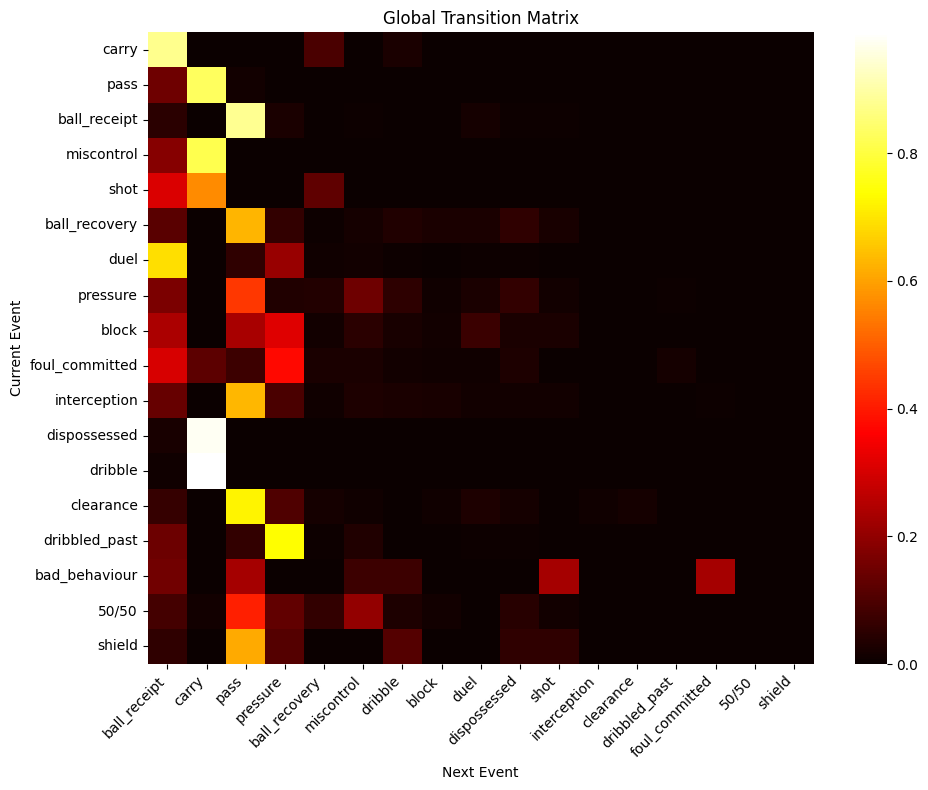

In [77]:
plot_transition_matrix(global_matrix, "Global Transition Matrix")

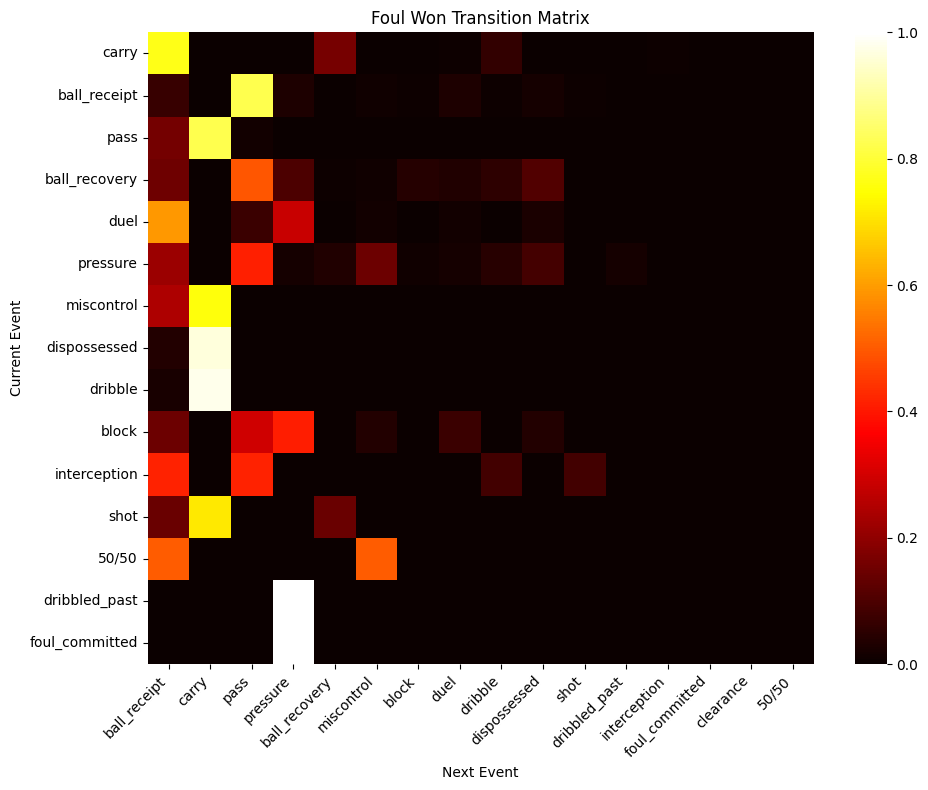

In [79]:
plot_transition_matrix(foul_matrix, "Foul Won Transition Matrix")

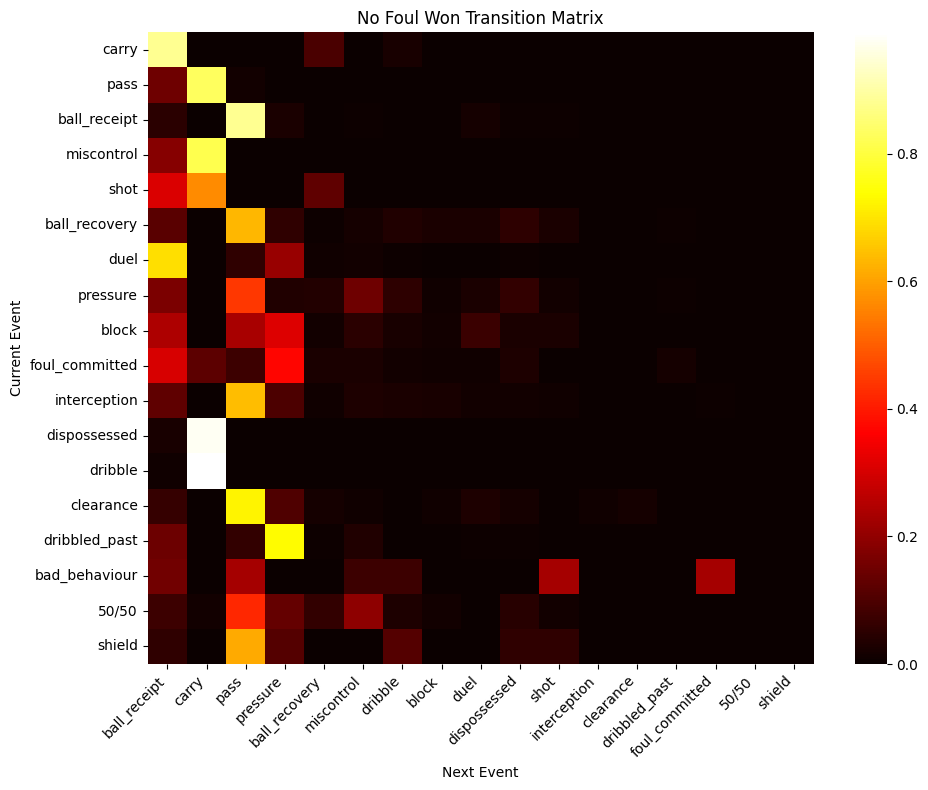

In [80]:
plot_transition_matrix(nonfoul_matrix, "No Foul Won Transition Matrix")

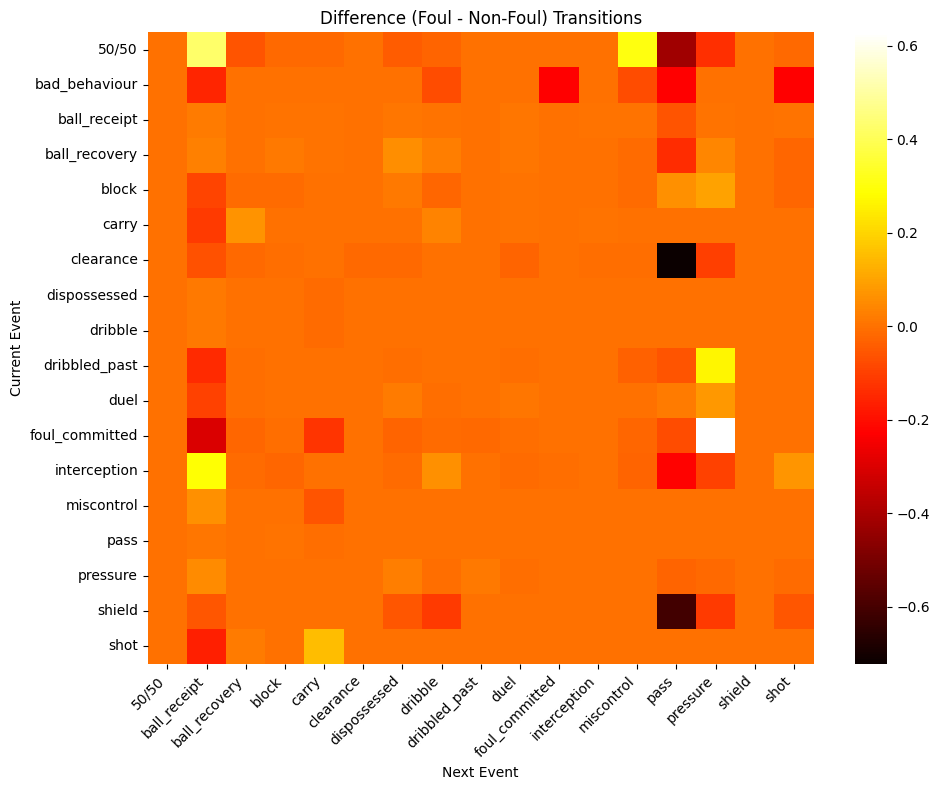

In [81]:
aligned = foul_matrix.sub(nonfoul_matrix, fill_value=0)
plot_transition_matrix(aligned, "Difference (Foul - Non-Foul) Transitions")

# Feature Transformers

For each possession chain, we can generate features which capture different context of the game, they are : 

**Spatio-Temporal Context**

- The location of the player plays a key part in the game. Referees might be inclined to award fouls near the penalty area
- If a player starts a possession in high contact area, they are likely to face more tackles and draw fouls
- Time of the game is related to player state, later in the game players will be more fatigued, increasing mistakes

**Event Context**

- Chaotic transitions lead to fouls
- If a player is under direct challenge, foul is more likely
- Set pieces and counter-pressing scenarios can affect foul dynamics

**Outcome Context**

- Longer passess places recievers under defensive duress
- Aerial contentions lead to more fouls than ground touches
- A successful dribble or duel affects the opponents, often inciting challenges

**Player & Team Context**

- Attackers and Midfielders are more likely to operate in foul prone areas
- Teams often have history, making the game more heated and prone to more fouls

**Sequential Context**

- Soccer is inherently sequential, past events affecting future outcome
- Successful dribble, passing chains can affect how the opponent reacts
- Knowing what happened before helps understand transient situations effectively

In [4]:
import ast
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

# ─── Helpers ──────────────────────────────────────────────────────────────────

def parse_loc(val):
    """Parse a stringified [x,y] into two floats."""
    try:
        coords = ast.literal_eval(val)
        if isinstance(coords, (list, tuple)) and len(coords) == 2:
            return coords
    except:
        pass
    return [np.nan, np.nan]

def zone_bin(xy, x_bins=10, y_bins=6):
    """Map (x,y) on 120×80 pitch to a grid bin index."""
    x, y = xy
    if np.isnan(x) or np.isnan(y):
        return np.nan
    xi = min(int(x / (120 / x_bins)), x_bins - 1)
    yi = min(int(y / (80  / y_bins)), y_bins - 1)
    return f"{xi}_{yi}"

# ─── Custom Transformers ─────────────────────────────────────────────────────

class SpatialTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        # X is a DataFrame with 'location' and optional 'pass.end_location', 'carry.end_location'
        df = pd.DataFrame(index=X.index)
        # parse starter location
        locs = X['location'].astype(str).apply(parse_loc).tolist()
        coords = np.array(locs)
        df['x'] = coords[:,0]
        df['y'] = coords[:,1]
        # pitch zone
        df['zone'] = [zone_bin(xy) for xy in locs]
        return df

class TemporalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        df = pd.DataFrame(index=X.index)
        df['minute'] = X['minute']
        df['second'] = X['second']
        df['half'] = X['period'].apply(lambda p: 'HT1' if p==1 else 'HT2')
        return df

class EventContextTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        df = pd.DataFrame(index=X.index)
        df['starter_type'] = X['type.name']  # Receipt vs Recovery
        df['under_pressure'] = X['under_pressure'].astype(int)
        df['counterpress']   = X['counterpress'].astype(int)
        df['play_pattern']   = X['play_pattern.name']
        return df

class PassOutcomeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        df = pd.DataFrame(index=X.index)
        df['pass_length']    = X['pass.length'].fillna(0)
        df['pass_dx']        = df['pass_length'] * np.cos(np.deg2rad(X['pass.angle'].fillna(0)))
        df['pass_dy']        = df['pass_length'] * np.sin(np.deg2rad(X['pass.angle'].fillna(0)))
        df['pass_height']    = X['pass.height.name']
        df['pass_type']      = X['pass.type.name']
        df['pass_body_part'] = X['pass.body_part.name']
        df['pass_success']   = X['pass.outcome.name'].apply(lambda o: 1 if o=='Successful' else 0)
        return df

class PlayerTeamContextTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        df = pd.DataFrame(index=X.index)
        # position grouping
        def map_role(pos):
            p = str(pos).lower()
            if any(t in p for t in ['back','defender','goalkeeper']): return 'Defense'
            if 'midfield' in p: return 'Midfield'
            if any(t in p for t in ['wing','forward','attacking']): return 'Attack'
            return 'Other'
        df['position_group'] = X['position.name'].apply(map_role)
        # you could add running counts here if you pass in possession-level df
        df['team'] = X['team.name']
        return df

# ─── Assemble the Full Pipeline ───────────────────────────────────────────────

feature_pipeline = FeatureUnion(transformer_list=[
    ('spatial', Pipeline([
        ('spat', SpatialTransformer()),
        ('num', StandardScaler()),        # scales x,y
        ('zone_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, 
                                   categories='auto'))
    ])),
    ('temporal', Pipeline([
        ('time', TemporalTransformer()),
        ('scale', StandardScaler()),
        ('time_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])),
    ('event_ctx', Pipeline([
        ('evt', EventContextTransformer()),
        ('evt_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])),
    ('pass_out', Pipeline([
        ('pout', PassOutcomeTransformer()),
        ('pout_num', StandardScaler()),   # scales pass_length, dx, dy
        ('pout_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])),
    ('plyr_tm', Pipeline([
        ('pt', PlayerTeamContextTransformer()),
        ('pt_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])),
])


In [13]:
events_df.columns

Index(['match_id', 'possession', 'index', 'type.name', 'player.name',
       'team.name'],
      dtype='object')

In [5]:
X_features = feature_pipeline.fit_transform(events_df)

ValueError: could not convert string to float: 'HT1'